# Compare LLM Types

Using locally loaded LLMs with Ollama

We will compare the behavior of several types of transformer based models:
- Base language models
- Fine tuned language models (instruct, code)
- Vision LLM
- LLM fine tuned for code

# Setup

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import sqlite3


from datetime import datetime, timedelta
from IPython.display import display, Markdown, clear_output
from pathlib import Path
from PIL import Image

## Setup LLM

In [2]:
def setup_clean_proxy():
    """Clear problematic proxy vars and set clean ones for VPN access"""
    print("Setting up clean proxy environment for VPN and LLM access...")
    env_backup = {}
    proxy_vars = ['http_proxy', 'https_proxy', 'HTTP_PROXY', 'HTTPS_PROXY', 'no_proxy', 'NO_PROXY']
    for var in proxy_vars:
        if var in os.environ:
            env_backup[var] = os.environ[var]
            del os.environ[var]
    
    os.environ['HTTPS_PROXY'] = 'http://127.0.0.1:16005'
    os.environ['HTTP_PROXY'] = 'http://127.0.0.1:16005'
    return env_backup

# Call at start
env_backup = setup_clean_proxy()

Setting up clean proxy environment for VPN and LLM access...


In [3]:
import ollama

### msg to llm

In [4]:
def send_message_to_llm(message, model, system_message=None, streaming=True, max_tokens=8000):
    """Send a message to the LLM and return the response"""
    display(Markdown(f"Model: `{model}`"))
    display(Markdown(f"Answer to: **{message}**"))
    options = {}
    if max_tokens:
        options['num_predict'] = max_tokens
    if streaming:
        output = display(Markdown('Computing ...'), display_id=True)
        stream = ollama. chat(
            model=model,
            messages=[{'role': 'user', 'content': message}],
            stream=streaming,
            options=options if options else None,
            )
        streamed = ""
        for chunk in stream:
            streamed += chunk['message']['content']
            # clear_output(wait=True)
            output.update(Markdown(streamed))

        print(f"Done! in {len(streamed):,d} characters.")
        return streamed
    else:
        output = display(Markdown('Computing ...'), display_id=True)
        response = ollama.chat(
            model=model, 
            messages=[{'role': 'user', 'content': message}], 
            stream=False,
            options=options if options else None,
        )
        output.update(Markdown(response['message']['content']))
        print(f"Done! in {len(response['message']['content']):,d} characters.")
        return response

### msg to thinking llm

In [5]:
def send_message_to_llm_with_thinking_stream(message, model, system_message=None, streaming=True, max_tokens=8000):
    """Send message and parse thinking vs answer sections while streaming"""
    display(Markdown(f"Model: `{model}`"))
    display(Markdown(f"Answer to: **{message}**"))
    
    options = {}
    if max_tokens:
        options['num_predict'] = max_tokens
    
    if streaming:
        # Create display handles for thinking and answer
        thinking_output = display(Markdown("### 🧠 Thinking Process\n```\n\n```"), display_id=True)
        answer_output = display(Markdown("### 💡 Final Answer\n\n"), display_id=True)
        
        stream = ollama.chat(
            model=model,
            messages=[{'role': 'user', 'content': message}],
            stream=True,
            options=options if options else None,
        )
        
        streamed = ""
        thinking = ""
        answer = ""
        in_think_tag = False
        
        for chunk in stream:
            content = chunk['message']['content']
            streamed += content
            
            # Check for <think> tag opening
            if '<think>' in streamed and not in_think_tag:
                in_think_tag = True
                # Split at <think>
                parts = streamed.split('<think>', 1)
                if len(parts) > 1:
                    thinking = parts[1]
            
            # Check for </think> tag closing
            elif '</think>' in streamed and in_think_tag:
                in_think_tag = False
                # Split to separate thinking from answer
                parts = streamed.split('</think>', 1)
                if len(parts) > 1:
                    thinking = parts[0].split('<think>', 1)[1] if '<think>' in parts[0] else ""
                    answer = parts[1]
                    # Update both displays
                    thinking_output.update(Markdown(f"### 🧠 Thinking Process\n```\n{thinking}\n```"))
                    answer_output.update(Markdown(f"### 💡 Final Answer\n{answer}"))
            
            # While inside think tags
            elif in_think_tag:
                # Extract thinking content
                if '<think>' in streamed:
                    thinking = streamed.split('<think>', 1)[1]
                    thinking_output.update(Markdown(f"### 🧠 Thinking Process\n```\n{thinking}\n```"))
            
            # After think tags (or no think tags)
            else:
                # Check if we already closed think tags
                if '</think>' in streamed:
                    parts = streamed.split('</think>', 1)
                    if len(parts) > 1:
                        answer = parts[1]
                        answer_output.update(Markdown(f"### 💡 Final Answer\n{answer}"))
                else:
                    # No think tags at all, just show as answer
                    answer_output.update(Markdown(f"### 💡 Final Answer\n{streamed}"))
        
        print(f"Done! in {len(streamed):,d} characters.")
        
        # Final parse to ensure clean separation
        think_match = re.search(r'<think>(.*?)</think>', streamed, re.DOTALL)
        if think_match:
            thinking = think_match.group(1).strip()
            answer = re.sub(r'<think>.*?</think>', '', streamed, flags=re.DOTALL).strip()
        else:
            thinking = None
            answer = streamed
        
        return {'thinking': thinking, 'answer': answer, 'full': streamed}
    
    else:
        # Non-streaming version (unchanged)
        output = display(Markdown('Computing ...'), display_id=True)
        response = ollama.chat(
            model=model, 
            messages=[{'role': 'user', 'content': message}], 
            stream=False,
            options=options if options else None,
        )
        content = response['message']['content']
        
        think_match = re.search(r'<think>(.*?)</think>', content, re.DOTALL)
        if think_match:
            thinking = think_match.group(1).strip()
            answer = re.sub(r'<think>.*?</think>', '', content, flags=re.DOTALL).strip()
            
            display(Markdown("### 🧠 Thinking Process"))
            display(Markdown(f"```\n{thinking}\n```"))
            display(Markdown("### 💡 Final Answer"))
            display(Markdown(answer))
        else:
            output.update(Markdown(content))
            thinking = None
            answer = content
        
        print(f"Done! in {len(content):,d} characters.")
        return {'thinking': thinking, 'answer': answer, 'full': content}

### image to VLLM

In [6]:
def send_image_to_llm(message, image_path, model='llava:7b', streaming=True, max_tokens=8000):
    """Send a message with an image to a vision LLM"""
    display(Markdown(f"Model: `{model}`"))
    display(Markdown(f"Question: **{message}**"))
    display(Markdown(f"Image File: **{image_path.name}**"))

    im = Image.open(image_path)
    max_size = (512, 512)
    im.thumbnail(max_size, Image.Resampling.LANCZOS)    

    options = {}
    if max_tokens:
        options['num_predict'] = max_tokens
    
    if streaming:
        output = display(Markdown('Computing ...'), display_id=True)
        stream = ollama.chat(
            model=model,
            messages=[{
                'role': 'user',
                'content': message,
                'images': [image_path]  # Pass image path
            }],
            stream=True,
            options=options if options else None,
        )
        streamed = ""
        for chunk in stream:
            streamed += chunk['message']['content']
            output.update(Markdown(streamed))
        
        print(f"Done! in {len(streamed):,d} characters.")
        display(im)
        return streamed
    else:
        output = display(Markdown('Computing ...'), display_id=True)
        response = ollama.chat(
            model=model,
            messages=[{
                'role': 'user',
                'content': message,
                'images': [image_path]
            }],
            stream=False,
            options=options if options else None,
        )
        output.update(Markdown(response['message']['content']))
        print(f"Done! in {len(response['message']['content']):,d} characters.")
        display(im)
        return response['message']['content']

## Setup sqlite database

### Create a database if it does not exist yet

In [7]:
db_dir = Path('../db')
db_dir.mkdir(exist_ok=True)

# Database path
db_path = db_dir / 'crm.db'

# Remove existing database to start fresh
if db_path.exists():
    db_path.unlink()

# Connect to database
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Create tables
cursor.execute('''
CREATE TABLE accounts (
    uid INTEGER PRIMARY KEY AUTOINCREMENT,
    account_name TEXT NOT NULL,
    city TEXT NOT NULL,
    country TEXT NOT NULL
)
''')

cursor.execute('''
CREATE TABLE products (
    uid INTEGER PRIMARY KEY AUTOINCREMENT,
    product_name TEXT NOT NULL,
    product_price REAL NOT NULL,
    delivery_leadtime INTEGER NOT NULL
)
''')

cursor.execute('''
CREATE TABLE orders (
    uid INTEGER PRIMARY KEY AUTOINCREMENT,
    account_id INTEGER NOT NULL,
    order_date TEXT NOT NULL,
    status TEXT NOT NULL,
    FOREIGN KEY (account_id) REFERENCES accounts(uid)
)
''')

cursor.execute('''
CREATE TABLE order_details (
    uid INTEGER PRIMARY KEY AUTOINCREMENT,
    order_id INTEGER NOT NULL,
    product_id INTEGER NOT NULL,
    quantity INTEGER NOT NULL,
    FOREIGN KEY (order_id) REFERENCES orders(uid),
    FOREIGN KEY (product_id) REFERENCES products(uid)
)
''')

# Insert dummy data for accounts
locations = [
    ('Shanghai', 'PRC'),
    ('Beijing', 'PRC'),
    ('Shenzhen', 'PRC'),
    ('Tokyo', 'Japan'),
    ('Seoul', 'Korea')
]

company_prefixes = ['TechStyle', 'FashionHub', 'ModernWear', 'GlobalTextile', 'UrbanThread', 
                   'StyleCraft', 'PremiumFabric', 'ElegantWear', 'TrendSetter', 'ChicOutfit',
                   'ClassicApparel', 'NovaDress', 'EliteGarment', 'SwiftFashion', 'LuxuryFit']

accounts_data = []
for i, prefix in enumerate(company_prefixes):
    city, country = random.choice(locations)
    accounts_data.append((f"{prefix} Inc", city, country))

cursor.executemany('INSERT INTO accounts (account_name, city, country) VALUES (?, ?, ?)', accounts_data)

# Insert dummy data for products (clothing items)
products_data = [
    ('Cotton T-Shirt', 19.99, 3),
    ('Denim Jeans', 59.99, 5),
    ('Leather Jacket', 149.99, 7),
    ('Wool Sweater', 79.99, 4),
    ('Silk Blouse', 89.99, 6),
    ('Linen Pants', 69.99, 4),
    ('Polo Shirt', 39.99, 3),
    ('Dress Shirt', 49.99, 4),
    ('Cargo Shorts', 34.99, 3),
    ('Hooded Sweatshirt', 54.99, 5),
    ('Blazer', 129.99, 6),
    ('Pencil Skirt', 44.99, 4),
    ('Maxi Dress', 99.99, 5),
    ('Cardigan', 64.99, 4),
    ('Chinos', 54.99, 4),
    ('Track Pants', 39.99, 3),
    ('Tank Top', 14.99, 2),
    ('Bomber Jacket', 119.99, 6),
    ('Trench Coat', 179.99, 8),
    ('Cashmere Scarf', 84.99, 5)
]

cursor.executemany('INSERT INTO products (product_name, product_price, delivery_leadtime) VALUES (?, ?, ?)', products_data)

# Insert dummy data for orders
order_statuses = ['Pending', 'Processing', 'Shipped', 'Delivered', 'Cancelled']
base_date = datetime(2024, 1, 1)

orders_data = []
for i in range(50):
    account_id = random.randint(1, len(accounts_data))
    days_offset = random.randint(0, 365)
    order_date = (base_date + timedelta(days=days_offset)).strftime('%Y-%m-%d')
    status = random.choice(order_statuses)
    orders_data.append((account_id, order_date, status))

cursor.executemany('INSERT INTO orders (account_id, order_date, status) VALUES (?, ?, ?)', orders_data)

# Insert dummy data for order_details
order_details_data = []
for order_id in range(1, 51):
    # Each order has 1-5 line items
    num_items = random.randint(1, 5)
    for _ in range(num_items):
        product_id = random.randint(1, len(products_data))
        quantity = random.randint(1, 10)
        order_details_data.append((order_id, product_id, quantity))

cursor.executemany('INSERT INTO order_details (order_id, product_id, quantity) VALUES (?, ?, ?)', order_details_data)

# Commit and close
conn.commit()
conn.close()

print(f"✓ Database created at: {db_path}")
print(f"✓ {len(accounts_data)} accounts inserted")
print(f"✓ {len(products_data)} products inserted")
print(f"✓ {len(orders_data)} orders inserted")
print(f"✓ {len(order_details_data)} order details inserted")

✓ Database created at: ../db/crm.db
✓ 15 accounts inserted
✓ 20 products inserted
✓ 50 orders inserted
✓ 150 order details inserted


### query_db

In [8]:
def query_db(sql_query, db_path='../db/crm.db'):
    """Execute a SQL query and return results as a pandas DataFrame"""
    conn = sqlite3.connect(db_path)
    try:
        df = pd.read_sql_query(sql_query, conn)
        return df
    finally:
        conn.close()


query_db("SELECT * FROM accounts LIMIT 5")

,uid,account_name,city,country
0,1,TechStyle Inc,Beijing,PRC
1,2,FashionHub Inc,Tokyo,Japan
2,3,ModernWear Inc,Seoul,Korea
3,4,GlobalTextile Inc,Shenzhen,PRC
4,5,UrbanThread Inc,Seoul,Korea


In [9]:
df = query_db(
    "SELECT * FROM sqlite_master WHERE type='table'"
)
db_schema = '\n'.join(df.sql.to_list())
print(db_schema)

CREATE TABLE accounts (
    uid INTEGER PRIMARY KEY AUTOINCREMENT,
    account_name TEXT NOT NULL,
    city TEXT NOT NULL,
    country TEXT NOT NULL
)
CREATE TABLE sqlite_sequence(name,seq)
CREATE TABLE products (
    uid INTEGER PRIMARY KEY AUTOINCREMENT,
    product_name TEXT NOT NULL,
    product_price REAL NOT NULL,
    delivery_leadtime INTEGER NOT NULL
)
CREATE TABLE orders (
    uid INTEGER PRIMARY KEY AUTOINCREMENT,
    account_id INTEGER NOT NULL,
    order_date TEXT NOT NULL,
    status TEXT NOT NULL,
    FOREIGN KEY (account_id) REFERENCES accounts(uid)
)
CREATE TABLE order_details (
    uid INTEGER PRIMARY KEY AUTOINCREMENT,
    order_id INTEGER NOT NULL,
    product_id INTEGER NOT NULL,
    quantity INTEGER NOT NULL,
    FOREIGN KEY (order_id) REFERENCES orders(uid),
    FOREIGN KEY (product_id) REFERENCES products(uid)
)


### sql_prompt

In [10]:
question = "What are the companies in the database?"

def sql_prompt(question):
    return f""" 
    ### Instructions:
    Your task is to convert a question into a SQL query, given a Postgres database schema.
    Adhere to these rules:
    - **Deliberately go through the question and database schema word by word** to appropriately answer the question
    - **Use Table Aliases** to prevent ambiguity. For example, `SELECT table1.col1, table2.col1 FROM table1 JOIN table2 ON table1.id = table2.id`.
    - When creating a ratio, always cast the numerator as float

    ### Input:
    Generate a SQL query that answers the question `{question}`.
    This query will run on a database whose schema is represented in this string:

    CREATE TABLE accounts (
        uid INTEGER PRIMARY KEY AUTOINCREMENT,
        company_name TEXT NOT NULL,
        city TEXT NOT NULL,
        country TEXT NOT NULL
    );

    CREATE TABLE products (
        uid INTEGER PRIMARY KEY AUTOINCREMENT,
        product_name TEXT NOT NULL,
        product_price REAL NOT NULL,
        delivery_leadtime INTEGER NOT NULL
    )
    ;

    CREATE TABLE orders (
        uid INTEGER PRIMARY KEY AUTOINCREMENT,
        account_id INTEGER NOT NULL,
        order_date TEXT NOT NULL,
        status TEXT NOT NULL,
        FOREIGN KEY (account_id) REFERENCES accounts(uid)
    )
    ;

    CREATE TABLE order_details (
        uid INTEGER PRIMARY KEY AUTOINCREMENT,
        order_id INTEGER NOT NULL,
        product_id INTEGER NOT NULL,
        quantity INTEGER NOT NULL,
        FOREIGN KEY (order_id) REFERENCES orders(uid),
        FOREIGN KEY (product_id) REFERENCES products(uid)
    )


    ### Response:
    Based on your instructions, here is the SQL query I have generated to answer the question : `{question}`:

    sql statement starts here:
    """

# print(sql_prompt(question) )

### send_message_llm_for_sql

In [11]:
def send_message_llm_for_sql(message, model, system_message=None, max_tokens=8000):
    """Send a message to the LLM and return the response"""
    display(Markdown(f"Model: `{model}`"))
    # display(Markdown(f"Answer to: **{message}**"))
    options = {}
    if max_tokens:
        options['num_predict'] = max_tokens
    # if streaming:
    # output = display(Markdown('Computing ...'), display_id=True)
    stream = ollama. chat(
        model=model,
        messages=[{'role': 'user', 'content': message}],
        stream=True,
        options=options if options else None,
        )
    streamed = ""
    for chunk in stream:
        streamed += chunk['message']['content']
        # output.update(Markdown(streamed))

    print(f"Done! in {len(streamed):,d} characters.")
    return streamed
    # else:
    # output = display(Markdown('Computing ...'), display_id=True)
    # response = ollama.chat(
    #     model=model, 
    #     messages=[{'role': 'user', 'content': message}], 
    #     stream=False,
    #     options=options if options else None,
    # )
    # output.update(Markdown(response['message']['content']))
    # print(f"Done! in {len(response['message']['content']):,d} characters.")
    # return response

### extract_sql

In [12]:
def extract_sql(response_text):
    """Extract SQL code from LLM response"""
    
    # Try to find SQL in code blocks first
    code_block_match = re.search(r'```sql\n(.*?)\n```', response_text, re.DOTALL | re.IGNORECASE)
    if code_block_match:
        return code_block_match.group(1).strip()
    
    # Try generic code blocks
    code_block_match = re.search(r'```\n(.*?)\n```', response_text, re.DOTALL)
    if code_block_match:
        return code_block_match.group(1).strip()
    
    # Look for lines starting with SQL keywords
    lines = response_text.strip().split('\n')
    sql_lines = []
    in_sql = False
    
    for line in lines:
        line_stripped = line.strip()
        # Start capturing when we see SQL keywords
        if re.match(r'^(SELECT|INSERT|UPDATE|DELETE|WITH|CREATE)', line_stripped, re.IGNORECASE):
            in_sql = True
        
        if in_sql:
            sql_lines.append(line)
            # Stop at semicolon
            if ';' in line:
                break
    
    if sql_lines:
        return '\n'.join(sql_lines).strip()
    
    # If nothing found, return the whole response
    return response_text.strip()

# Compare LLM types

In [13]:
models = sorted([e['model'] for e in ollama.list()['models']])
models

['bge-m3:latest',
 'codellama:7b',
 'deepseek-r1:7b',
 'deepseek-r1:8b',
 'gemma3:4b',
 'granite3.2-vision:latest',
 'llama3.1:8b',
 'llama3.2:1b-instruct-fp16',
 'llama3.2:1b-text-fp16',
 'llama3.2:3b',
 'llava:7b',
 'mxbai-embed-large:335m',
 'nomic-embed-text:latest',
 'qwen2.5:3b',
 'qwen2.5:7b',
 'qwen3:8b',
 'sqlcoder:7b']

## Use a LLM with Ollama

In [14]:
model_checkpoint = 'gemma3:4b'
query = "Why is the sky blue?"

output = send_message_to_llm(query, model_checkpoint, streaming=True)

Model: `gemma3:4b`

Answer to: **Why is the sky blue?**

The blue color of the sky is a fascinating phenomenon caused by a process called **Rayleigh scattering**. Here's a breakdown of why it happens:

**1. Sunlight and its Colors:**

* Sunlight is actually made up of *all* the colors of the rainbow. We perceive it as white light, but it’s a mixture of red, orange, yellow, green, blue, indigo, and violet.

**2. Scattering by Air Molecules:**

* As sunlight enters the Earth's atmosphere, it collides with tiny air molecules (mostly nitrogen and oxygen).
* **Rayleigh scattering** is the key. This type of scattering happens when light interacts with particles that are *much* smaller than its wavelength.

**3. Wavelength and Scattering:**

* Shorter wavelengths of light (blue and violet) are scattered *much* more strongly than longer wavelengths (red and orange).  This is because the scattering is more efficient with shorter wavelengths. Think of it like throwing a small ball (blue light) against a bumpy surface – it's more likely to bounce off in different directions.  A larger ball (red light) is less affected.

**4. Why Blue, Not Violet?**

* Violet light has the shortest wavelength and is scattered the most. However, our eyes are more sensitive to blue light.  Also, the sun emits slightly less violet light than blue light.  This combination makes the sky appear blue to us.


**Think of it like this:** Imagine throwing a handful of small marbles (blue light) and a handful of larger bowling balls (red light) at a field of tiny bumps. The marbles will bounce around everywhere, while the bowling balls will mostly roll straight through.

**In summary:** The sky is blue because blue light from the sun is scattered more effectively by air molecules in the atmosphere.

---

**Resources for more information:**

* **NASA:** [https://science.nasa.gov/sky-observing/why-is-the-sky-blue/](https://science.nasa.gov/sky-observing/why-is-the-sky-blue/)
* **National Geographic:** [https://www.nationalgeographic.com/science/phenomena/sky-blue/](https://www.nationalgeographic.com/science/phenomena/sky-blue/)



Do you want to explore any specific aspects of this phenomenon, such as:

*   Why sunsets are red?
*   How this applies to other planets?

Done! in 2,207 characters.


## Compare Base Model and Instruct Model

We pick `llama3.2` and use the base model and the finetuned model for instructions. We will use a very small model version.
- **base** (text): `llama3.2:1b-text-fp16`
- **instruct** (instruct): `llama3.2:1b-instruct-fp16`

In [15]:
base_model = 'llama3.2:1b-text-fp16'
instruct_model = 'llama3.2:1b-instruct-fp16'
query = "Why is the sky blue?"

### Instruct Model

In [16]:
output = send_message_to_llm(query, instruct_model, streaming=True)  

Model: `llama3.2:1b-instruct-fp16`

Answer to: **Why is the sky blue?**

The sky appears blue to us because of a phenomenon called Rayleigh scattering, named after the British physicist Lord Rayleigh. He discovered that when sunlight enters Earth's atmosphere, it encounters tiny molecules of gases such as nitrogen and oxygen.

These gas molecules are much smaller than the wavelength of light, so they scatter the light in all directions. But since blue light has a shorter wavelength than red light, it is scattered more efficiently by these gas molecules. This is why the sky typically appears blue, especially during the daytime when the sun is overhead.

The amount of scattering that occurs depends on the intensity of the sunlight and the altitude at which it enters the atmosphere. At higher altitudes, there are fewer gas molecules, so less light is scattered in a particular direction. As a result, the sky can appear more red or orange during these times.

It's worth noting that the sky can take on other colors depending on the time of day and the type of cloud formations present. For example, during sunrise and sunset, the sky can take on hues of red, orange, and pink due to the scattering of light by atmospheric particles.

Done! in 1,169 characters.


### Base Model

In [17]:
output = send_message_to_llm(query, base_model, streaming=True)

Model: `llama3.2:1b-text-fp16`

Answer to: **Why is the sky blue?**

 What’s inside a star? Why does it change color? These are some of the questions kids ask as they explore the world around them. How can we explain why things look different from one another?
In this 1/3rd hour, students engage in an activity to demonstrate how colors appear to be separated by wavelengths or frequencies.
What is a frequency and what is it used for?
Students will investigate the properties of a spectrum produced by a prism and compare them to those observed with their eyes. Students will discover that light travels through space at different speeds depending on its wavelength, which explains why we see colors in different shades when looking at objects from different angles.
This is an activity that you can do any time during your investigation into the properties of white light, but it works best if you have a prism and some paper cut into small pieces. It is also helpful to use two or three books so that students have something to compare as they observe their experiment with each book.
What are some ways to look at colors?
Light travels through space at different speeds depending on its wavelength (frequency).
This activity requires the teacher to make sure that students know how a prism works and how light is refracted when it passes from one medium to another. The teacher should also be aware of which instruments in their lab have been used and set up an appropriate number of books for each student.
Students will investigate the properties of white light, using a prism and comparing its properties with those observed by looking through a glass block that has been cut into small pieces.
The first half hour is spent discussing what happens when we look at things in different ways. The second half is devoted to the investigation of the spectral composition of sunlight and how it differs from one object or place to another, as well as its effect on the eyes (the spectrum). Finally, students will look at their own books and try to find other examples of colors.
What are some ways that we can look at color?
The first half hour is spent discussing what happens when we look at things in different ways. The second half is devoted to the investigation of the spectral composition of sunlight and how it differs from one object or place to another, as well as its effect on the eyes (the spectrum). Finally, students will look at their own books and try to find other examples of colors.
What are some ways that we can understand color?
What does this mean? In the first hour of class, students will be asked about how light travels through space. Students will be able to identify different colors by looking at them under a microscope or magnifying glass.
Students can also look for differences in color when they travel from one place to another (e.g., a beach vs. an office building). They can also observe how the sun affects their eyes and what happens when you look at things from different angles (e.g., trees and grass).
What are some ways that we can understand color?
Students will be asked about how light travels through space. Students can identify different colors by looking at them under a microscope or magnifying glass.
A microscope is an instrument used to observe small details, such as the size of cells or molecules in a sample. The first half hour consists of discussing what happens when we look at things from different angles and comparing their appearance (e.g., trees vs. grass). Students will then be asked if there are any ways that we can understand color and how they might do so.
We use light to see everything around us, including the colors that make up our world. We also see objects as shades of gray or black-and-white because they reflect different amounts of blue and red wavelengths (which can cause them not to be seen at all). These two types of light are called ‘visible’ and we call these kinds of phenomena “colors”.

Done! in 3,911 characters.


## Thinking Model

In [18]:
thinking_model = 'deepseek-r1:7b'
query = "Why is the sky blue?"

In [168]:
output = send_message_to_llm_with_thinking_stream(query, thinking_model, streaming=True)

Model: `deepseek-r1:7b`

Answer to: **Why is the sky blue?**

### 🧠 Thinking Process
```

Okay, so I'm trying to figure out why the sky looks blue. I remember it's something related to light and how we see colors, but I'm not exactly sure about the details. Let me think this through step by step.

First, I know that white light is actually made up of all the different colors in the spectrum, like red, orange, yellow, green, blue, indigo, and violet. This is called the electromagnetic spectrum, right? So when we say the sky looks blue, it's because our atmosphere is interacting with this white light somehow.

Wait, but why isn't the sky another color or even more bright? Maybe it has to do with how the Earth's atmosphere scatters or absorbs sunlight. I've heard something about Rayleigh scattering before. Isn't that when smaller particles in the air scatter light in all directions?

So if white light is broken down into these colors, blue light has a shorter wavelength compared to red or orange. If the atmosphere scatters shorter wavelengths more than longer ones, then wouldn't the sky appear blue? But why does it look so clear on a clear day instead of a different color when there are clouds in the sky?

Oh right, I think Rayleigh scattering is responsible for this. The shorter wavelength of blue light gets scattered more by the molecules and small particles in the atmosphere. This makes the sky appear blue during the day because our eyes are more sensitive to blue light.

But then, why does the sky turn red or orange during sunrise or sunset? Isn't that also due to Rayleigh scattering? Or is it something else? I think at those times, the sunlight has to pass through a lot more atmosphere. So instead of being scattered in all directions evenly, most of the blue light gets scattered away by the time we see it near the horizon. That leaves us with the longer wavelengths like red and orange. This phenomenon must be why sunsets are colored.

So putting this together: when sunlight enters the Earth's atmosphere, it interacts with molecules and small particles. Blue light scatters more in all directions due to its shorter wavelength. As a result, we see blue during the day because our eyes are more sensitive to it. But at sunrise or sunset, the blue light is scattered away by the atmosphere so much that other colors like red and orange become more prominent.

But wait, why isn't the sky completely white when all blue light is gone? I mean, if blue is no longer predominant, shouldn't the sky reflect the underlying colors of the sun better? Or does it have to do with our eyes being more sensitive to blue in the daytime?

Also, what about during cloudy days or times without direct sunlight? The sky might be darker because there's less scattering happening. Maybe the amount of scattering depends on the angle and the presence of particles.

Another thing I'm a bit confused about is why the sky appears as a gradient from one color to another at different altitudes. Does that have something to do with how light scatters differently when passing through various layers of the atmosphere?

I think it's all coming down to the scattering of different wavelengths and how our eyes perceive these colors more or less depending on the time of day. So during the day, blue is scattered so much that the sky appears blue. At sunrise and sunset, most of the blue light is filtered out, leaving reds, oranges, and yellows.

But I'm still a bit unsure about why Rayleigh scattering specifically affects shorter wavelengths more. Maybe it's because the scattering cross-section increases with smaller wavelengths? So for blue, which has a very short wavelength (around 450 nm), this effect is pronounced, making it scatter much more than longer wavelengths like red.

Also, how does the atmosphere know which color to scatter when? Is it just based on the composition of air and the particles in it?

I guess another factor could be that during the day, the sun is high in the sky, so sunlight has to pass through less atmosphere. But wait, actually, I think it's more about the angle: when the sun is low on the horizon, light has to travel through a longer path through the atmosphere. So at those angles, more of the blue light is scattered out.

So during sunrise and sunset, because the light has to pass through more atmosphere, most of the blue light gets scattered away by molecules and particles in the air, leaving the reds and oranges visible.

On the other hand, when the sun is high, like at midday, the light doesn't have as far a path through the atmosphere. So less blue is scattered, so our eyes catch more of it, making the sky appear blue.

But then why isn't the sky during noon as red or orange? I mean, sometimes people say that some days are clearer and others not, but generally, the sky is blue when there's no sun obstructions, like on a clear day without clouds. So maybe even at midday, some of the scattering still leaves enough red or orange for us to see it as white if the background isn't clear.

But I think overall, during midday, the combination of scattered blue and less scattered longer wavelengths (like yellow) makes the sky appear blue rather than any other color. During sunrise and sunset, the dominance of the longer wavelengths creates those warm colors we see.

So to sum it up: The sky appears blue because shorter wavelength light scatters more in the atmosphere due to Rayleigh scattering, making the sky look blue during the day when sunlight is abundant. At sunrise and sunset, this effect is lessened, so other colors like red and orange become more visible. Our eyes also have varying sensitivity to different wavelengths, with higher sensitivity to blue light during the day.

I think that covers it, but I'm still a bit fuzzy on some details, especially regarding why exactly Rayleigh scattering affects shorter wavelengths more than longer ones. Maybe that's something to do with how the cross-section for scattering decreases with increasing wavelength? Or perhaps it's related to the frequency of the light and how molecules respond to different frequencies.

Another thought: maybe it has to do with the size of the particles in the atmosphere. Smaller particles scatter shorter wavelengths more effectively, so if Rayleigh scattering is happening due to small air molecules, that would explain why blue scatters more.

But then again, isn't there also something called Mie scattering? I think that's when larger particles are involved, but in our atmosphere, we mainly have smaller particles like nitrogen and oxygen molecules. So Rayleigh scattering is probably the main factor here.

So putting it all together: The sky appears blue because of Rayleigh scattering by small air molecules which preferentially scatter shorter (blue) wavelengths more than longer ones. Our eyes are more sensitive to blue light during the day, so we perceive the sky as blue. During sunrise and sunset, this effect causes other colors like red and orange to become more prominent.

```

### 💡 Final Answer


The sky appears blue primarily due to a phenomenon known as Rayleigh scattering, which is governed by the principles of atmospheric optics. Here's a detailed explanation:

1. **Rayleigh Scattering**: This occurs when sunlight interacts with molecules in Earth's atmosphere. Sunlight, composed of all colors of the visible spectrum, has different wavelengths: violet and blue (shorter wavelengths) versus red and orange (longer wavelengths).

2. **Scattering Effect**: Rayleigh scattering is more effective for shorter wavelengths because it is inversely proportional to the fourth power of the wavelength. This means that blue light (shorter wavelength) is scattered much more than red light (longer wavelength). As a result, blue light scatters in all directions, making the sky appear blue during the day.

3. **Daytime Observation**: During midday, sunlight passes through less atmosphere, so blue light scatters more efficiently, scattering away from direct view while longer wavelengths reach us more clearly. This combination of scattered blue and some yellow or other visible light makes the sky appear blue.

4. **Sunrise and Sunset**: At these times, sunlight has to pass through a greater thickness of Earth's atmosphere. This causes most of the blue light to be scattered away by molecules in the air, leaving behind longer wavelengths like red and orange, which are more visible. Thus, sunsets often display beautiful gradients of colors.

5. **Eyes' Sensitivity**: Human eyes are more sensitive to blue light during the day, enhancing our perception of the sky's blue hue. This sensitivity contributes to how we perceive the sky as blue when direct sunlight is present but less so at other times.

In summary, the sky appears blue due to Rayleigh scattering by small atmospheric molecules, which preferentially scatters shorter wavelengths of light, combined with the eye's sensitivity to these colors during daylight hours.

Done! in 8,919 characters.


## Vision LLM

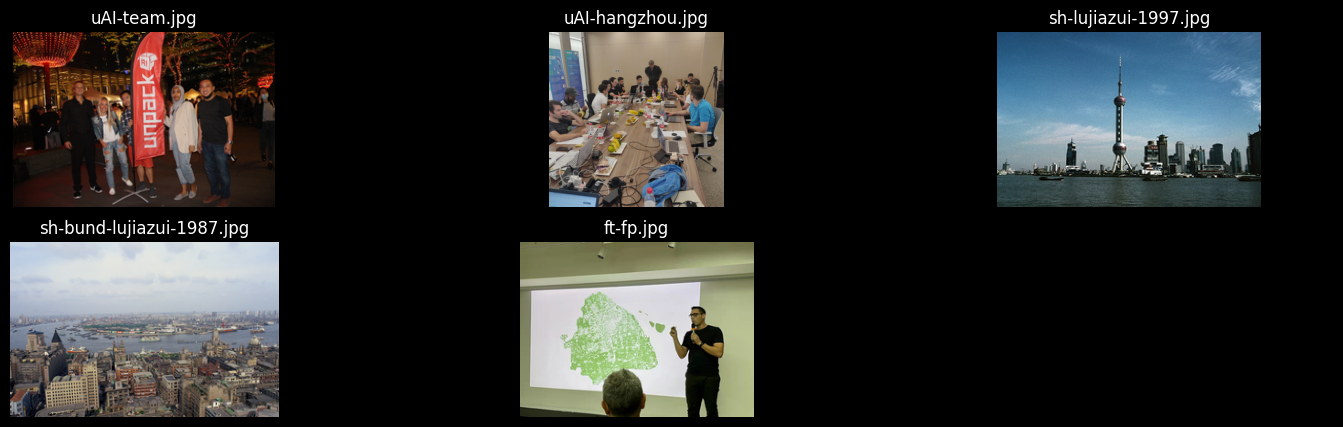

In [21]:
p2imgs = Path('../imgs')
assert p2imgs.is_dir(), "The directory 'imgs' does not exist."
loimgs = sorted([f for f in p2imgs.glob('*.jpg')])
loimgs.reverse()

fig, axs = plt.subplots(2, len(loimgs)//2 if len(loimgs)%2==0 else len(loimgs)//2 + 1, figsize=(18, 5))
for ax in axs.flatten(): ax.axis('off')
for ax, f in zip(axs.flatten(), loimgs):
    im = Image.open(f)
    im.thumbnail((256, 256), Image.Resampling.LANCZOS)
    ax.imshow(im)
    ax.set_title(f.name)
plt.show()    

Model: `granite3.2-vision:latest`

Question: **What is in this image? Give me a detailed description**

Image File: **uAI-hangzhou.jpg**


The image depicts a collaborative work environment, likely during a workshop or team meeting. The presence of laptops suggests that the individuals are engaged in tasks that require digital tools, such as programming, writing, or data analysis. The casual attire and relaxed postures indicate an informal setting, possibly within a startup culture where formal dress codes are not enforced. The use of bananas as a makeshift tabletop could imply a creative or unconventional approach to workspace organization. The presence of the camera on a tripod suggests that the event is being documented, which might be for promotional purposes or to share with participants and stakeholders. The banner in the background provides context, indicating that this is an organized event, possibly part of a larger conference or series of workshops. Overall, the image captures a moment of focused activity within a modern, informal workspace setting.

Done! in 937 characters.


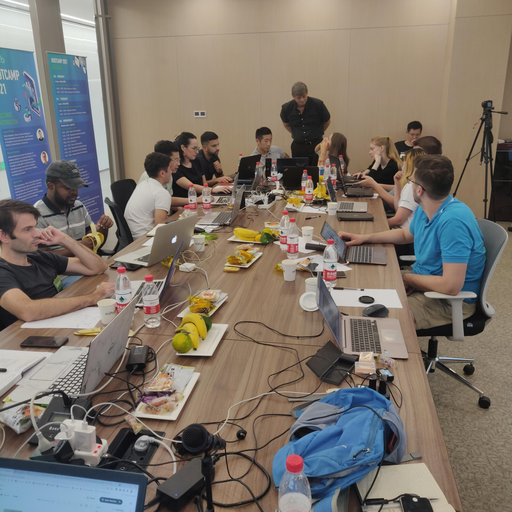

Model: `granite3.2-vision:latest`

Question: **What is in this image? Give me a detailed description**

Image File: **sh-lujiazui-1997.jpg**


The image captures a cityscape with a prominent skyscraper that resembles the Oriental Pearl Tower, which is an iconic landmark of Shanghai, China. The tower's distinctive red and white color scheme stands out against the clear blue sky. The surrounding buildings are modern in design, suggesting a contemporary urban environment. The presence of water indicates that this city may be situated along a river or bay, which is common for many major cities due to its strategic importance for trade and transportation. The absence of people and vehicles could imply the photo was taken at a time when traffic is minimal or from an angle where such details are not discernible. Overall, the image presents a snapshot of urban development in a city that has embraced modern architecture and infrastructure.

Done! in 802 characters.


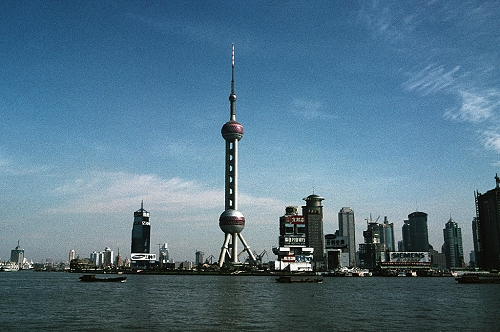

Model: `granite3.2-vision:latest`

Question: **What is in this image? Give me a detailed description**

Image File: **sh-bund-lujiazui-1987.jpg**


The image captures a cityscape viewed from above, likely taken from a high vantage point such as an observation deck or a tall building. The dense arrangement of buildings suggests a metropolitan area with a significant population density. The river serves as a central feature, connecting the various parts of the city and providing a natural boundary between different areas. The presence of boats indicates that this is a working harbor, which could be used for commercial shipping or transportation. The overcast sky suggests it might be an early morning or late afternoon when the sun is not at its peak, resulting in softer lighting and less intense shadows. There are no visible landmarks or signs that would allow for a precise identification of the city; however, the architecture and layout could suggest it is a major urban center in East Asia, possibly China, given the style of the buildings and the density of the city. The image does not provide any direct information about the specific location or time without additional context.

Done! in 1,048 characters.


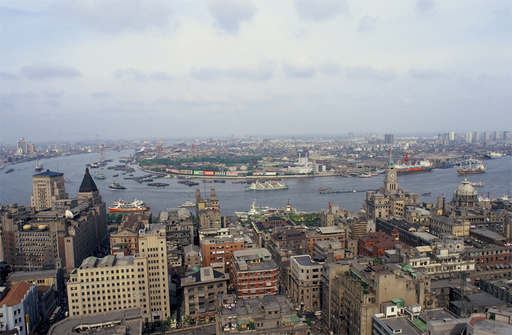

In [23]:
model_checkpoint = 'llava:7b'
model_checkpoint = 'granite3.2-vision:latest'

for im in loimgs[1:-1]:
    output = send_image_to_llm(message="What is in this image? Give me a detailed description", image_path=im, model=model_checkpoint, streaming=True)

## Code Model

In [24]:
model_checkpoint = 'codellama:7b'
message = "how do i create a function in python to add a and b?"


output = send_message_to_llm(message=message, model=model_checkpoint, streaming=True)

Model: `codellama:7b`

Answer to: **how do i create a function in python to add a and b?**


To create a function in Python that adds two numbers, you can use the `def` keyword followed by the name of the function, a list of parameters (in this case just `a` and `b`), and the code that implements the functionality. Here's an example:
```
def add(a, b):
    return a + b
```
You can then call this function with two arguments like this:
```
result = add(3, 5)
print(result) # Output: 8
```
Alternatively, you can use the `lambda` keyword to define an anonymous function. Here's an example:
```
add = lambda a, b: a + b
result = add(3, 5)
print(result) # Output: 8
```

Done! in 576 characters.


Test the code:

In [25]:
def add(a, b):
    return a + b

print(add(3, 4))

7


In [26]:
model_checkpoint = 'codellama:7b'
message = "what is the minimum code to create a random forest classifer in scikit-learn?"


output = send_message_to_llm(message=message, model=model_checkpoint, streaming=True)

Model: `codellama:7b`

Answer to: **what is the minimum code to create a random forest classifer in scikit-learn?**


To create a random forest classifier in scikit-learn, you can use the `RandomForestClassifier` class. Here is an example of how to use it:
```
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split

# Load a sample dataset
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Train a random forest classifier on the training data
clf = RandomForestClassifier(n_estimators=10, random_state=0)
clf.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = clf.predict(X_test)
```
This code will train a random forest classifier on the first two features of the Iris dataset and predict the labels of the test set. The `n_estimators` parameter specifies the number of decision trees to use in the random forest, and the `random_state` parameter ensures that the same training data is used every time the model is trained.

Done! in 1,087 characters.


Test the code:

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split

# Load the dataset
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=10, random_state=42)

# Train the model on the training data
clf.fit(X_train, y_train)

# Predict the labels of the test data
y_pred = clf.predict(X_test)

# Evaluate the performance of the model
accuracy = clf.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.7666666666666667


## SQL Model

### Function for simple query to database

In [28]:
query_db("SELECT * FROM accounts")

,uid,account_name,city,country
0,1,TechStyle Inc,Beijing,PRC
1,2,FashionHub Inc,Tokyo,Japan
2,3,ModernWear Inc,Seoul,Korea
3,4,GlobalTextile Inc,Shenzhen,PRC
4,5,UrbanThread Inc,Seoul,Korea
5,6,StyleCraft Inc,Shenzhen,PRC
6,7,PremiumFabric Inc,Shanghai,PRC
7,8,ElegantWear Inc,Shanghai,PRC
8,9,TrendSetter Inc,Shenzhen,PRC
9,10,ChicOutfit Inc,Tokyo,Japan


In [29]:
model_checkpoint = 'codellama:7b'
message = f"""
This is a database scheme: {db_schema}. 
Give me the sql statement to list all companies in the database.
"""

output = send_message_llm_for_sql(message=message, model=model_checkpoint)
print('\nLLM output:')
display(Markdown(f"```ascii\n{output}```"))
print('')
print('Extracted Code:')
display(Markdown(f"```sql\n{extract_sql(output)}\n```"))

Model: `codellama:7b`

Done! in 374 characters.

LLM output:


```ascii
Here is an SQL query to list all companies in the database:
```
SELECT DISTINCT account_name FROM accounts;
```
This query uses the `DISTINCT` keyword to return only unique values from the `account_name` column of the `accounts` table. The result set will contain a list of all companies in the database, along with their corresponding `uid` and other columns if they exist.```


Extracted Code:


```sql
SELECT DISTINCT account_name FROM accounts;
```

Test the SQL:

In [30]:
sql = extract_sql(output)

query_db(sql)

,account_name
0,TechStyle Inc
1,FashionHub Inc
2,ModernWear Inc
3,GlobalTextile Inc
4,UrbanThread Inc
5,StyleCraft Inc
6,PremiumFabric Inc
7,ElegantWear Inc
8,TrendSetter Inc
9,ChicOutfit Inc


In [31]:
model_checkpoint = 'codellama:7b'
co_name = 'FashionHub Inc'

message = f"Give me the sql statement to get all orders which were placed by {co_name} with all details."


output = send_message_llm_for_sql(message=message, model=model_checkpoint)
print('\nLLM output:')
display(Markdown(f"```ascii\n{output}```"))
print('')
print('Extracted Code:')
display(Markdown(f"```sql\n{extract_sql(output)}\n```"))

Model: `codellama:7b`

Done! in 708 characters.

LLM output:


```ascii

To get all orders that were placed by FashionHub Inc with all details, you can use a SQL query like this:
```
SELECT * 
FROM orders
WHERE company = 'FashionHub Inc';
```
This will retrieve all the orders that were placed by FashionHub Inc and return all the available columns in the `orders` table.

If you want to retrieve specific details for each order, you can add additional columns to the `SELECT` clause, such as the order date, total cost, or customer name:
```
SELECT *, order_date, total_cost, customer_name 
FROM orders
WHERE company = 'FashionHub Inc';
```
This will return all the available columns in the `orders` table, along with the order date, total cost, and customer name for each order.```


Extracted Code:


```sql
SELECT * 
FROM orders
WHERE company = 'FashionHub Inc';
```

In [32]:
try:
    result = query_db(extract_sql(output))
    display(result)
except Exception as e:
    print(f"Error executing SQL: \n{e}")

Error executing SQL: 
Execution failed on sql 'SELECT * 
FROM orders
WHERE company = 'FashionHub Inc';': no such column: company


In [33]:
# Query all order details for FashionHub Inc
co_name = 'FashionHub Inc'
sql = f"""
SELECT 
    a.account_name,
    a.city,
    a.country,
    o.uid as order_id,
    o.order_date,
    o.status,
    p.product_name,
    p.product_price,
    od.quantity,
    (p.product_price * od.quantity) as line_total
FROM accounts a
JOIN orders o ON a.uid = o.account_id
JOIN order_details od ON o.uid = od.order_id
JOIN products p ON od.product_id = p.uid
WHERE a.account_name = "{co_name}"
ORDER BY o.order_date DESC, o.uid
"""
df = query_db(sql)
print(f"{co_name} ordered a total of {df.line_total.sum():,.2f}")
display(df)

FashionHub Inc ordered a total of 529.92


,account_name,city,country,order_id,order_date,status,product_name,product_price,quantity,line_total
0,FashionHub Inc,Tokyo,Japan,19,2024-07-30,Cancelled,Cashmere Scarf,84.99,2,169.98
1,FashionHub Inc,Tokyo,Japan,19,2024-07-30,Cancelled,Denim Jeans,59.99,3,179.97
2,FashionHub Inc,Tokyo,Japan,19,2024-07-30,Cancelled,Denim Jeans,59.99,3,179.97


### Agentic Version of SQL LLM

In [34]:
def llm_query_loop(message, max_attempts=10, model='codellama:7b'):
    """Loop to refine SQL query based on LLM feedback"""
    attempt = 0
    correct_sql = False
    outputs = []
    sqls = []
    while not correct_sql and attempt < max_attempts:
        display(Markdown(f"**Attempt {attempt+1}**:"))
        # Get LLM response
        output = send_message_llm_for_sql(message=message, model=model)   
        outputs.append(output)
        # Extract SQL
        sql = extract_sql(output)
        sqls.append(sql)
        display(Markdown(f"```sql\n{sql}\n```"))
        # Test it
        try:
            result = query_db(sql)
            print(f"\n✓ Query successful!")
            correct_sql = True
            return sql, result, sqls, outputs
        except Exception as e:
            print(f"\n✗ Query {attempt+1} failed test!")
            attempt += 1
            # Modify the user message to provide the question, the wrong SQL and the error message
            message = f"""
            This is a database schema: {db_schema}
            Generate a SQL statement that answer the following question:
                Question: {question}
            Return ONLY the SQL statement without explanation. Start directly with SELECT/INSERT/UPDATE/DELETE.
            
            Generated SQL statement:
            ```sql
            {sql}
            ```
            When running the above SQL, the following error was raised: {e}

            Correct the SQL statement and provide the corrected SQL statement for the question.
            Return ONLY the SQL statement without explanation. Start directly with SELECT/INSERT/UPDATE/DELETE.
            """
    print("\n✗ Query failed for too many attempts.")
    return None, None, sqls, outputs


In [35]:
def ask_llm_for_sql(question, model='codellama:7b'):
    """Ask LLM for SQL and automatically extract and test it"""
    message = f"""
    This is a database schema: {db_schema}
    Generate a SQL statement that answer the following question:
        Question: {question}
    Return ONLY the SQL statement without explanation. Start directly with SELECT/INSERT/UPDATE/DELETE.
    """

    max_attempts = 5
    sql, result, sqls, outputs = llm_query_loop(message, max_attempts, model)
    if sql:
        return sql, result, sqls, outputs
    else:
        max_attempts = 5
        sql, result, sqls, outputs = llm_query_loop(message, max_attempts, model)
        if sql:
            return sql, result, sqls, outputs
        else:
            print(f"\n✗ Query {max_attempts} attempts failed test!")    
            return None, None, sqls, outputs

In [36]:
question = "List of all that companies"

sql, result, sqls, output = ask_llm_for_sql(question)

if result is not None:
    display(result)

**Attempt 1**:

Model: `codellama:7b`

Done! in 44 characters.


```sql
SELECT DISTINCT account_name FROM accounts;
```


✓ Query successful!


,account_name
0,TechStyle Inc
1,FashionHub Inc
2,ModernWear Inc
3,GlobalTextile Inc
4,UrbanThread Inc
5,StyleCraft Inc
6,PremiumFabric Inc
7,ElegantWear Inc
8,TrendSetter Inc
9,ChicOutfit Inc


In [91]:
question = """
Get the list of all orders with all order and product details for account FashionHub Inc. 
Add the total price per order line. 
Order them by ascending order date
"""

sql, result, sqls, outputs = ask_llm_for_sql(question)

if result is not None:
    display(result)

**Attempt 1**:

Model: `codellama:7b`

Done! in 424 characters.


```sql
SELECT orders.uid, orders.order_date, orders.status, products.product_name, products.product_price, order_details.quantity, order_details.product_id, (products.product_price * order_details.quantity) AS total_price
FROM orders 
INNER JOIN order_details ON orders.uid = order_details.order_id
INNER JOIN products ON order_details.product_id = products.uid
WHERE account_name="FashionHub Inc."
ORDER BY orders.order_date ASC;
```


✗ Query 1 failed test!


**Attempt 2**:

Model: `codellama:7b`

Done! in 467 characters.


```sql
SELECT orders.uid, orders.order_date, orders.status, products.product_name, products.product_price, order_details.quantity, order_details.product_id, (products.product_price * order_details.quantity) AS total_price
FROM orders 
INNER JOIN order_details ON orders.uid = order_details.order_id
INNER JOIN products ON order_details.product_id = products.uid
WHERE accounts.account_name="FashionHub Inc."
ORDER BY orders.order_date ASC;
```


✗ Query 2 failed test!


**Attempt 3**:

Model: `codellama:7b`

Done! in 459 characters.


```sql
SELECT orders.uid, orders.order_date, orders.status, products.product_name, products.product_price, order_details.quantity, order_details.product_id, (products.product_price * order_details.quantity) AS total_price
FROM orders 
INNER JOIN order_details ON orders.uid = order_details.order_id
INNER JOIN products ON order_details.product_id = products.uid
WHERE accounts.account_name="FashionHub Inc."
ORDER BY orders.order_date ASC;
```


✗ Query 3 failed test!


**Attempt 4**:

Model: `codellama:7b`

Done! in 851 characters.


```sql
SELECT orders.uid, orders.order_date, orders.status, products.product_name, products.product_price, order_details.quantity, order_details.product_id, (products.product_price * order_details.quantity) AS total_price
FROM orders 
INNER JOIN order_details ON orders.uid = order_details.order_id
INNER JOIN products ON order_details.product_id = products.uid
WHERE accounts.account_name="FashionHub Inc."
ORDER BY orders.order_date ASC;
```


✗ Query 4 failed test!


**Attempt 5**:

Model: `codellama:7b`

Done! in 1,030 characters.


```sql
SELECT orders.uid, orders.order_date, orders.status, products.product_name, products.product_price, order_details.quantity, order_details.product_id, (products.product_price * order_details.quantity) AS total_price
FROM orders 
INNER JOIN order_details ON orders.uid = order_details.order_id
INNER JOIN products ON order_details.product_id = products.uid
WHERE accounts.account_name="FashionHub Inc."
ORDER BY orders.order_date ASC;
```


✗ Query 5 failed test!

✗ Query failed for too many attempts.


**Attempt 1**:

Model: `codellama:7b`

Done! in 550 characters.


```sql
`SELECT orders.uid, orders.order_date, orders.status, products.product_name, products.product_price, order_details.quantity, order_details.uid AS order_detail_uid, order_details.order_id AS order_detail_order_id, order_details.product_id AS order_detail_product_id 
    FROM orders 
    JOIN order_details ON orders.uid = order_details.order_id 
    JOIN products ON order_details.product_id = products.uid 
    WHERE orders.account_id IN (SELECT uid FROM accounts WHERE account_name LIKE '%FashionHub Inc%') 
    ORDER BY orders.order_date ASC;`
```


✗ Query 1 failed test!


**Attempt 2**:

Model: `codellama:7b`

Done! in 1,458 characters.


```sql
SELECT orders.uid, orders.order_date, orders.status, products.product_name, products.product_price, order_details.quantity, order_details.uid AS order_detail_uid, order_details.order_id AS order_detail_order_id, order_details.product_id AS order_detail_product_id 
    FROM orders 
    JOIN order_details ON orders.uid = order_details.order_id 
    JOIN products ON order_details.product_id = products.uid 
    WHERE orders.account_id IN (SELECT uid FROM accounts WHERE account_name LIKE '%FashionHub Inc%') 
    ORDER BY orders.order_date ASC;
```


✓ Query successful!


,uid,order_date,status,product_name,product_price,quantity,order_detail_uid,order_detail_order_id,order_detail_product_id
0,31,2024-03-20,Cancelled,Trench Coat,179.99,5,98,31,19
1,31,2024-03-20,Cancelled,Track Pants,39.99,9,99,31,16
2,31,2024-03-20,Cancelled,Bomber Jacket,119.99,2,100,31,18
3,7,2024-10-18,Delivered,Silk Blouse,89.99,2,20,7,5
4,7,2024-10-18,Delivered,Silk Blouse,89.99,6,21,7,5
5,7,2024-10-18,Delivered,Maxi Dress,99.99,7,22,7,13
6,7,2024-10-18,Delivered,Track Pants,39.99,1,23,7,16
7,7,2024-10-18,Delivered,Cargo Shorts,34.99,8,24,7,9
8,13,2024-11-06,Delivered,Trench Coat,179.99,2,44,13,19
9,8,2024-11-17,Shipped,Cardigan,64.99,9,25,8,14


In [92]:
# Query all order details for FashionHub Inc
co_name = 'FashionHub Inc'
sql = f"""
SELECT 
    a.account_name,
    a.city,
    a.country,
    o.uid as order_id,
    o.order_date,
    o.status,
    p.product_name,
    p.product_price,
    od.quantity,
    (p.product_price * od.quantity) as line_total
FROM accounts a
JOIN orders o ON a.uid = o.account_id
JOIN order_details od ON o.uid = od.order_id
JOIN products p ON od.product_id = p.uid
WHERE a.account_name = "{co_name}"
ORDER BY o.order_date ASC
"""
df = query_db(sql)
print(f"{co_name} ordered a total of {df.line_total.sum():,.2f}")
display(df)

FashionHub Inc ordered a total of 4,834.36


,account_name,city,country,order_id,order_date,status,product_name,product_price,quantity,line_total
0,FashionHub Inc,Tokyo,Japan,31,2024-03-20,Cancelled,Trench Coat,179.99,5,899.95
1,FashionHub Inc,Tokyo,Japan,31,2024-03-20,Cancelled,Track Pants,39.99,9,359.91
2,FashionHub Inc,Tokyo,Japan,31,2024-03-20,Cancelled,Bomber Jacket,119.99,2,239.98
3,FashionHub Inc,Tokyo,Japan,7,2024-10-18,Delivered,Silk Blouse,89.99,2,179.98
4,FashionHub Inc,Tokyo,Japan,7,2024-10-18,Delivered,Silk Blouse,89.99,6,539.94
5,FashionHub Inc,Tokyo,Japan,7,2024-10-18,Delivered,Maxi Dress,99.99,7,699.93
6,FashionHub Inc,Tokyo,Japan,7,2024-10-18,Delivered,Track Pants,39.99,1,39.99
7,FashionHub Inc,Tokyo,Japan,7,2024-10-18,Delivered,Cargo Shorts,34.99,8,279.92
8,FashionHub Inc,Tokyo,Japan,13,2024-11-06,Delivered,Trench Coat,179.99,2,359.98
9,FashionHub Inc,Tokyo,Japan,8,2024-11-17,Shipped,Cardigan,64.99,9,584.91


In [98]:
question = """
List all orders for account FashionHub Inc, including the total price for each order. 
List the following fields: account name, order date, order ID and total price of the order
"""

sql, result, sqls, outputs = ask_llm_for_sql(question)

if result is not None:
    display(result)

**Attempt 1**:

Model: `codellama:7b`

Done! in 454 characters.


```sql
```SELECT accounts.account_name AS "Account Name", orders.order_date AS "Order Date", orders.uid AS "Order ID", SUM(order_details.quantity * products.product_price) AS "Total Price" 
        FROM accounts, orders, order_details, products 
        WHERE orders.account_id = accounts.uid AND orders.uid = order_details.order_id AND order_details.product_id = products.uid 
        GROUP BY orders.uid 
        HAVING account_name = 'FashionHub Inc';```
```


✗ Query 1 failed test!


**Attempt 2**:

Model: `codellama:7b`

Done! in 500 characters.


```sql
SELECT accounts.account_name AS "Account Name", orders.order_date AS "Order Date", orders.uid AS "Order ID", SUM(order_details.quantity * products.product_price) AS "Total Price" 
        FROM accounts, orders, order_details, products 
        WHERE orders.account_id = accounts.uid AND orders.uid = order_details.order_id AND order_details.product_id = products.uid 
        GROUP BY orders.uid 
        HAVING accounts.account_name = 'FashionHub Inc';
```


✓ Query successful!


,Account Name,Order Date,Order ID,Total Price
0,FashionHub Inc,2024-10-18,7,1739.76
1,FashionHub Inc,2024-11-17,8,1234.78
2,FashionHub Inc,2024-11-06,13,359.98
3,FashionHub Inc,2024-03-20,31,1499.84


In [103]:
question = """
List all orders with all order details for accounts FashionHub Inc and for PremiumFabric Inc.
Show the following fields: account name, order date, order ID, product name, product price, quantity and line total.
Order by account ID first, then by order date.
"""

sql, result, sqls, outputs = ask_llm_for_sql(question)

if result is not None:
    display(result)

**Attempt 1**:

Model: `codellama:7b`

Done! in 516 characters.


```sql
SELECT accounts.account_name, orders.order_date, orders.uid AS "Order ID", products.product_name, products.product_price, order_details.quantity, order_details.line_total 
FROM accounts 
INNER JOIN orders ON orders.account_id = accounts.uid 
INNER JOIN order_details ON order_details.order_id = orders.uid 
INNER JOIN products ON order_details.product_id = products.uid 
WHERE accounts.account_name LIKE '%FashionHub Inc%' OR accounts.account_name LIKE '%PremiumFabric Inc%' ORDER BY accounts.uid, orders.order_date;
```


✗ Query 1 failed test!


**Attempt 2**:

Model: `codellama:7b`

Done! in 1,041 characters.


```sql
SELECT accounts.account_name, orders.order_date, orders.uid AS "Order ID", products.product_name, products.product_price, order_details.quantity, order_details.line_total 
FROM accounts 
INNER JOIN orders ON orders.account_id = accounts.uid 
INNER JOIN order_details ON order_details.order_id = orders.uid 
INNER JOIN products ON order_details.product_id = products.uid 
WHERE accounts.account_name LIKE '%FashionHub Inc%' OR accounts.account_name LIKE '%PremiumFabric Inc%' ORDER BY accounts.uid, orders.order_date;
```


✗ Query 2 failed test!


**Attempt 3**:

Model: `codellama:7b`

Done! in 553 characters.


```sql
SELECT accounts.account_name, orders.order_date, orders.uid AS "Order ID", products.product_name, products.product_price, order_details.quantity, order_details.line_total 
FROM accounts 
INNER JOIN orders ON orders.account_id = accounts.uid 
INNER JOIN order_details ON order_details.order_id = orders.uid 
INNER JOIN products ON order_details.product_id = products.uid 
WHERE accounts.account_name LIKE '%FashionHub Inc%' OR accounts.account_name LIKE '%PremiumFabric Inc%' ORDER BY accounts.uid, orders.order_date;
```


✗ Query 3 failed test!


**Attempt 4**:

Model: `codellama:7b`

Done! in 1,080 characters.


```sql
SELECT accounts.account_name, orders.order_date, orders.uid AS "Order ID", products.product_name, products.product_price, order_details.quantity, order_details.line_total
FROM accounts
INNER JOIN orders ON orders.account_id = accounts.uid
INNER JOIN order_details ON order_details.order_id = orders.uid
INNER JOIN products ON order_details.product_id = products.uid
WHERE accounts.account_name LIKE '%FashionHub Inc%' OR accounts.account_name LIKE '%PremiumFabric Inc%' ORDER BY accounts.uid, orders.order_date;
```


✗ Query 4 failed test!


**Attempt 5**:

Model: `codellama:7b`

Done! in 524 characters.


```sql
SELECT accounts.account_name, orders.order_date, orders.uid AS "Order ID", products.product_name, products.product_price, order_details.quantity, order_details.line_total
FROM accounts
INNER JOIN orders ON orders.account_id = accounts.uid
LEFT JOIN order_details ON order_details.order_id = orders.uid
LEFT JOIN products ON order_details.product_id = products.uid
WHERE accounts.account_name LIKE '%FashionHub Inc%' OR accounts.account_name LIKE '%PremiumFabric Inc%' ORDER BY accounts.uid, orders.order_date;
```


✗ Query 5 failed test!

✗ Query failed for too many attempts.


**Attempt 1**:

Model: `codellama:7b`

Done! in 483 characters.


```sql
SELECT a.account_name AS "Account Name", o.order_date AS "Order Date", o.uid AS "Order ID", p.product_name AS "Product Name", p.product_price AS "Product Price", od.quantity AS "Quantity", (p.product_price * od.quantity) AS "Line Total"
FROM orders AS o
JOIN order_details AS od ON o.uid = od.order_id
JOIN products AS p ON od.product_id = p.uid
JOIN accounts AS a ON o.account_id = a.uid
WHERE a.account_name IN ('FashionHub Inc', 'PremiumFabric Inc')
ORDER BY a.uid, o.order_date;
```


✓ Query successful!


,Account Name,Order Date,Order ID,Product Name,Product Price,Quantity,Line Total
0,FashionHub Inc,2024-03-20,31,Trench Coat,179.99,5,899.95
1,FashionHub Inc,2024-03-20,31,Track Pants,39.99,9,359.91
2,FashionHub Inc,2024-03-20,31,Bomber Jacket,119.99,2,239.98
3,FashionHub Inc,2024-10-18,7,Silk Blouse,89.99,2,179.98
4,FashionHub Inc,2024-10-18,7,Silk Blouse,89.99,6,539.94
5,FashionHub Inc,2024-10-18,7,Maxi Dress,99.99,7,699.93
6,FashionHub Inc,2024-10-18,7,Track Pants,39.99,1,39.99
7,FashionHub Inc,2024-10-18,7,Cargo Shorts,34.99,8,279.92
8,FashionHub Inc,2024-11-06,13,Trench Coat,179.99,2,359.98
9,FashionHub Inc,2024-11-17,8,Cardigan,64.99,9,584.91


# End